## Assignment interview

### 1. Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression




### 2. Loading the data

In [2]:
monthly_payment_df = pd.read_csv("Monthly_payments.csv")
user_id_df = pd.read_csv("user_id_table.csv")

In [3]:
#check the monthly payment tables
monthly_payment_df

,user_id,date,payment
0,73,2017-10-01 00:00:00.000000 UTC,1
1,216,2017-10-01 00:00:00.000000 UTC,1
2,3586,2017-10-01 00:00:00.000000 UTC,1
3,4197,2017-10-01 00:00:00.000000 UTC,1
4,4680,2017-10-01 00:00:00.000000 UTC,1
...,...,...,...
198110,47915,2017-12-01 00:00:00.000000 UTC,1
198111,48003,2017-12-01 00:00:00.000000 UTC,1
198112,48774,2017-12-01 00:00:00.000000 UTC,1
198113,49814,2017-12-01 00:00:00.000000 UTC,1


In [4]:
#check the user_id table
user_id_df

,user_id,f_0,f_1,f_2,f_3,f_4
0,117,0.185834,0.257087,0.681947,0.343844,0.562220
1,140,0.274930,0.042934,0.627473,0.534509,0.493101
2,159,0.548740,0.605102,0.369127,0.384560,0.220441
3,175,0.308355,0.600812,0.556980,0.167359,0.453548
4,297,0.724011,0.186172,0.323603,0.579623,0.021604
...,...,...,...,...,...,...
49995,49585,0.691765,0.368827,0.268830,0.536567,0.158915
49996,49751,0.569852,0.289845,0.461525,0.374787,0.487635
49997,49782,0.540032,0.502296,0.185834,0.075061,0.644900
49998,49908,0.420014,0.449307,0.200692,0.535565,0.542775


### 3. Feature engineering

In [5]:
#convert the date into pandas.Timestamp and add date features like year, month, quarter etc..
monthly_payment_df["date"] = monthly_payment_df["date"].apply(lambda x: x.split(" ")[0])
monthly_payment_df["date"] = pd.to_datetime(monthly_payment_df["date"])
monthly_payment_df["year"] = monthly_payment_df["date"].dt.year
monthly_payment_df["quarter"] = monthly_payment_df["date"].dt.quarter
monthly_payment_df["month"] = monthly_payment_df["date"].dt.month
monthly_payment_df["dayofyear"] = monthly_payment_df["date"].dt.dayofyear


#joining the table with the user table
df_merged = pd.merge(monthly_payment_df, user_id_df, on="user_id", how="inner")
df_merged = df_merged.sort_values(["user_id", "date"])
df_merged


,user_id,date,payment,year,quarter,month,dayofyear,f_0,f_1,f_2,f_3,f_4
21418,0,2016-02-01,1,2016,1,2,32,0.224480,0.388817,0.460769,0.573753,0.506882
187133,0,2016-03-01,1,2016,1,3,61,0.224480,0.388817,0.460769,0.573753,0.506882
102211,0,2016-04-01,1,2016,2,4,92,0.224480,0.388817,0.460769,0.573753,0.506882
165824,0,2016-05-01,1,2016,2,5,122,0.224480,0.388817,0.460769,0.573753,0.506882
83542,0,2016-06-01,1,2016,2,6,153,0.224480,0.388817,0.460769,0.573753,0.506882
...,...,...,...,...,...,...,...,...,...,...,...,...
183728,49996,2016-09-01,1,2016,3,9,245,0.605773,0.609872,0.137083,0.472622,0.137594
32565,49997,2016-10-01,1,2016,4,10,275,0.323261,0.285334,0.438968,0.772342,0.157740
156940,49997,2016-11-01,1,2016,4,11,306,0.323261,0.285334,0.438968,0.772342,0.157740
101160,49998,2016-04-01,1,2016,2,4,92,0.507291,0.759812,0.088509,0.353841,0.179736


In [6]:
df_merged['days_from_first_date'] = (
    df_merged.groupby('user_id')['date']
    .transform(lambda x: (x - x.min()).dt.days)
)

# Calculate the cumulative sum of payments for each user
df_merged['number_payments_cumulative'] = df_merged.groupby('user_id')['date'].transform('cumcount') + 1  # Start counting from 1

# Calculate the cumulative sum of payments for each user within every year
df_merged['number_payments_cumulative_per_year'] = df_merged.groupby(['user_id', 'year'])['date'].transform('cumcount') + 1  # Start counting from 1

# Calculate the cumulative sum of payments for each user per year per quarter
df_merged['number_payments_cumulative_per_year_per_quarter'] = df_merged.groupby(['user_id', 'year', 'quarter'])['date'].transform('cumcount') + 1  # Start counting from 1
df_merged


,user_id,date,payment,year,quarter,month,dayofyear,f_0,f_1,f_2,f_3,f_4,days_from_first_date,number_payments_cumulative,number_payments_cumulative_per_year,number_payments_cumulative_per_year_per_quarter
21418,0,2016-02-01,1,2016,1,2,32,0.224480,0.388817,0.460769,0.573753,0.506882,0,1,1,1
187133,0,2016-03-01,1,2016,1,3,61,0.224480,0.388817,0.460769,0.573753,0.506882,29,2,2,2
102211,0,2016-04-01,1,2016,2,4,92,0.224480,0.388817,0.460769,0.573753,0.506882,60,3,3,1
165824,0,2016-05-01,1,2016,2,5,122,0.224480,0.388817,0.460769,0.573753,0.506882,90,4,4,2
83542,0,2016-06-01,1,2016,2,6,153,0.224480,0.388817,0.460769,0.573753,0.506882,121,5,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183728,49996,2016-09-01,1,2016,3,9,245,0.605773,0.609872,0.137083,0.472622,0.137594,31,2,2,2
32565,49997,2016-10-01,1,2016,4,10,275,0.323261,0.285334,0.438968,0.772342,0.157740,0,1,1,1
156940,49997,2016-11-01,1,2016,4,11,306,0.323261,0.285334,0.438968,0.772342,0.157740,31,2,2,2
101160,49998,2016-04-01,1,2016,2,4,92,0.507291,0.759812,0.088509,0.353841,0.179736,0,1,1,1


### 4. Creating the target variable
As outlined in the task, the objective is to predict whether a user is likely to miss any payments within the three months following a given date. To create the target variable, the following function assigns values of 0 and 1 based on these criteria:

- If the user has failed payment events within the three months after the given date, the target value will be set to 1. If no such events occur, the target value will be set to 0. Initially, a 90-day window was used for simplicity; however, this doesn't always align perfectly with varying month lengths. To address this, I used the relativedelta function to calculate an exact three-month period from the current date.

- If the user has no payment records after their most recent payment date, or if the time window extends beyond the user's available payment history, I assume the user will miss their next payments, and thus the target value is set to 1.

In [7]:
def build_target_variable_rolling(df):
    # Sort by user_id and date
    df = df.sort_values(by=['user_id', 'date']).copy()

    # Compute the maximum date for each user
    user_max_date = df.groupby('user_id')['date'].max().to_dict()

    targets = []

    # Iterate over each row
    for i, row in df.iterrows():
        user_id = row['user_id']
        current_date = row['date']
        end_date = current_date + relativedelta(months=3)

        # Check the max date for the specific user
        max_user_date = user_max_date[user_id]

        # Find future payments within the next 3 months
        future_payments = df[
            (df['user_id'] == user_id) &
            (df['date'] > current_date) &
            (df['date'] <= end_date)
        ]

        # Assign target based on future payments
        target = 0 if not future_payments.empty else 1

        # Handle edge case where the window extends beyond the user's max date
        if end_date > max_user_date:
            target = 1

        targets.append(target)

    # Assign target column
    df['target'] = targets
    return df

df_merged = build_target_variable_rolling(df_merged)
df_merged


,user_id,date,payment,year,quarter,month,dayofyear,f_0,f_1,f_2,f_3,f_4,days_from_first_date,number_payments_cumulative,number_payments_cumulative_per_year,number_payments_cumulative_per_year_per_quarter,target
21418,0,2016-02-01,1,2016,1,2,32,0.224480,0.388817,0.460769,0.573753,0.506882,0,1,1,1,0
187133,0,2016-03-01,1,2016,1,3,61,0.224480,0.388817,0.460769,0.573753,0.506882,29,2,2,2,0
102211,0,2016-04-01,1,2016,2,4,92,0.224480,0.388817,0.460769,0.573753,0.506882,60,3,3,1,0
165824,0,2016-05-01,1,2016,2,5,122,0.224480,0.388817,0.460769,0.573753,0.506882,90,4,4,2,0
83542,0,2016-06-01,1,2016,2,6,153,0.224480,0.388817,0.460769,0.573753,0.506882,121,5,5,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183728,49996,2016-09-01,1,2016,3,9,245,0.605773,0.609872,0.137083,0.472622,0.137594,31,2,2,2,1
32565,49997,2016-10-01,1,2016,4,10,275,0.323261,0.285334,0.438968,0.772342,0.157740,0,1,1,1,1
156940,49997,2016-11-01,1,2016,4,11,306,0.323261,0.285334,0.438968,0.772342,0.157740,31,2,2,2,1
101160,49998,2016-04-01,1,2016,2,4,92,0.507291,0.759812,0.088509,0.353841,0.179736,0,1,1,1,1


In [8]:
df_merged["target"].value_counts()

target
0    107018
1     91097
Name: count, dtype: int64

In [9]:
# Select the constant features for clustering
cluster_features = df_merged[['f_0', 'f_1', 'f_2', 'f_3', 'f_4']]
scaler = StandardScaler()
cluster_features_scaled = scaler.fit_transform(cluster_features)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
df_merged['cluster'] = kmeans.fit_predict(cluster_features_scaled)

c:\Users\matte\anaconda3\envs\myenv1\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\matte\anaconda3\envs\myenv1\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\matte\anaconda3\envs\myenv1\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\matte\anaconda3\envs\myenv1\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\matte\anaconda3\envs\myenv1\Lib\subprocess.py", line 1538

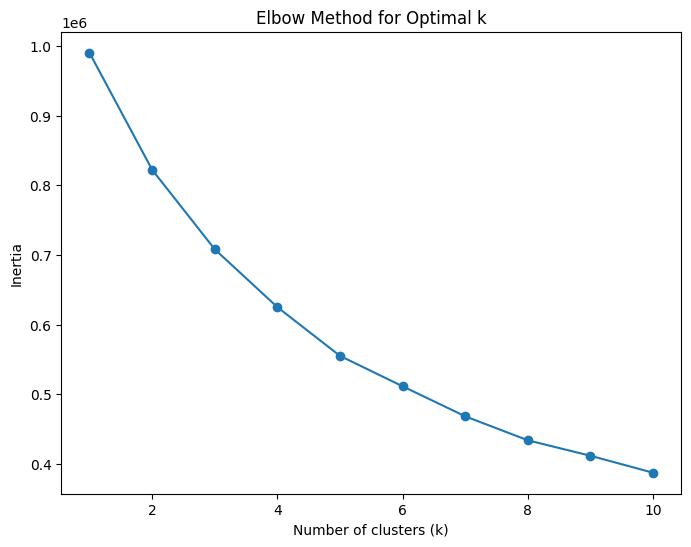

In [10]:
# Inertia calculation for different k values
inertia = []
k_range = range(1, 11)  # Check for k between 1 and 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [11]:
# Assuming df_merged['cluster'] holds your cluster labels and 'target' is your target variable
features_to_plot = df_merged[["user_id", 'f_0', 'f_1', 'f_2', 'f_3', 'f_4']]  # Select features to plot
features_to_plot['cluster'] = df_merged['cluster']  # Add cluster labels
features_to_plot['target'] = df_merged['target']  # Add target variable for hue

features_to_plot


C:\Users\matte\AppData\Local\Temp\ipykernel_17472\1474367826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_to_plot['cluster'] = df_merged['cluster']  # Add cluster labels
C:\Users\matte\AppData\Local\Temp\ipykernel_17472\1474367826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_to_plot['target'] = df_merged['target']  # Add target variable for hue


,user_id,f_0,f_1,f_2,f_3,f_4,cluster,target
21418,0,0.224480,0.388817,0.460769,0.573753,0.506882,0,0
187133,0,0.224480,0.388817,0.460769,0.573753,0.506882,0,0
102211,0,0.224480,0.388817,0.460769,0.573753,0.506882,0,0
165824,0,0.224480,0.388817,0.460769,0.573753,0.506882,0,0
83542,0,0.224480,0.388817,0.460769,0.573753,0.506882,0,0
...,...,...,...,...,...,...,...,...
183728,49996,0.605773,0.609872,0.137083,0.472622,0.137594,2,1
32565,49997,0.323261,0.285334,0.438968,0.772342,0.157740,0,1
156940,49997,0.323261,0.285334,0.438968,0.772342,0.157740,0,1
101160,49998,0.507291,0.759812,0.088509,0.353841,0.179736,2,1


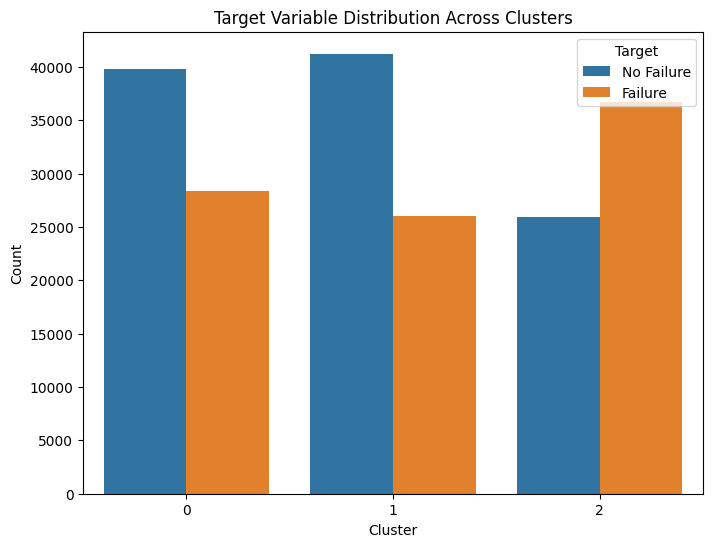

In [12]:
# Plot the distribution of the target variable across clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', hue='target', data=df_merged)
plt.title('Target Variable Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Target', labels=['No Failure', 'Failure'])
plt.show()

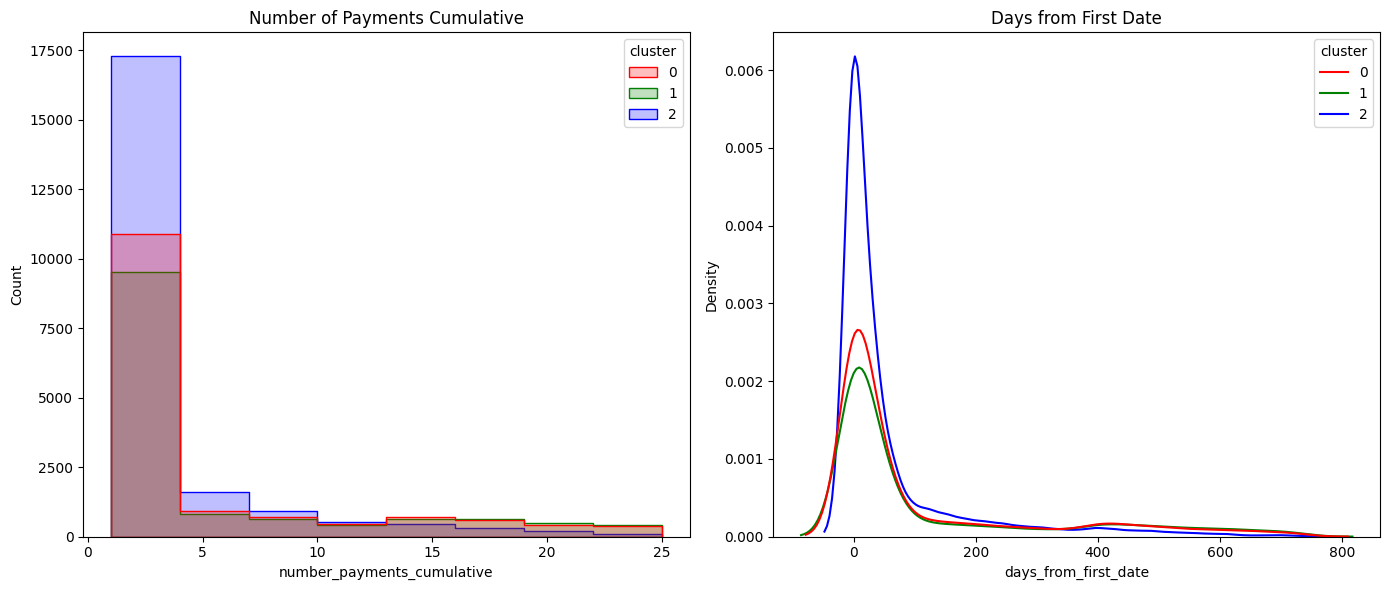

In [13]:
# Group by 'cluster' and calculate the last value for 'number_payments_cumulative'
cluster_history_payments = df_merged.groupby(['cluster', "user_id"]).agg({'number_payments_cumulative': 'last', "days_from_first_date": "last"})
cluster_history_payments = cluster_history_payments.reset_index()
#cluster_history_payments.groupby("cluster").agg({"number_payments_cumulative": "mean"})

# Set figure size
plt.figure(figsize=(14, 6))
palette = ["red", "green", "blue"]
# Create a 1x2 grid of subplots (2 charts in a row)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(data=cluster_history_payments, x="number_payments_cumulative", binwidth=3, hue="cluster", element="step", palette=palette)
plt.title('Number of Payments Cumulative')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.kdeplot(data=cluster_history_payments, x="days_from_first_date", hue="cluster", palette=palette)
plt.title('Days from First Date')

# Show the plots
plt.tight_layout()  # Adjust subplots to fit in the figure area
plt.show()


In [14]:
#Check the correlation among features
# Compute correlation matrix
# corr_matrix = df_merged.corr()

# # Plot heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.title("Feature Correlation Heatmap")
# plt.show()

### 5. Splitting the data

In [15]:
train_users = []
val_users = []
test_users = []

for i in range(0, 3):
    filtered_users = cluster_history_payments.groupby("cluster")["user_id"].unique()[i]
    train, temp = train_test_split(filtered_users, test_size=0.4, random_state=42)  # 60% train
    val, test = train_test_split(temp, test_size=0.5, random_state=42)  # 20% val, 20% test

    # # Add the resulting user_ids to the appropriate lists
    train_users.append(train.tolist())
    val_users.append(val.tolist())
    test_users.append(test.tolist())

# Combine all the train, val, and test user_ids into a single list if needed
train_users = [item for sublist in train_users for item in sublist]
val_users = [item for sublist in val_users for item in sublist]
test_users = [item for sublist in test_users for item in sublist]

df_merged['train'] = df_merged['user_id'].isin(train_users)
df_merged['val'] = df_merged['user_id'].isin(val_users)
df_merged['test'] = df_merged['user_id'].isin(test_users)

df_merged


,user_id,date,payment,year,quarter,month,dayofyear,f_0,f_1,f_2,...,f_4,days_from_first_date,number_payments_cumulative,number_payments_cumulative_per_year,number_payments_cumulative_per_year_per_quarter,target,cluster,train,val,test
21418,0,2016-02-01,1,2016,1,2,32,0.224480,0.388817,0.460769,...,0.506882,0,1,1,1,0,0,False,False,True
187133,0,2016-03-01,1,2016,1,3,61,0.224480,0.388817,0.460769,...,0.506882,29,2,2,2,0,0,False,False,True
102211,0,2016-04-01,1,2016,2,4,92,0.224480,0.388817,0.460769,...,0.506882,60,3,3,1,0,0,False,False,True
165824,0,2016-05-01,1,2016,2,5,122,0.224480,0.388817,0.460769,...,0.506882,90,4,4,2,0,0,False,False,True
83542,0,2016-06-01,1,2016,2,6,153,0.224480,0.388817,0.460769,...,0.506882,121,5,5,3,0,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183728,49996,2016-09-01,1,2016,3,9,245,0.605773,0.609872,0.137083,...,0.137594,31,2,2,2,1,2,True,False,False
32565,49997,2016-10-01,1,2016,4,10,275,0.323261,0.285334,0.438968,...,0.157740,0,1,1,1,1,0,False,True,False
156940,49997,2016-11-01,1,2016,4,11,306,0.323261,0.285334,0.438968,...,0.157740,31,2,2,2,1,0,False,True,False
101160,49998,2016-04-01,1,2016,2,4,92,0.507291,0.759812,0.088509,...,0.179736,0,1,1,1,1,2,False,False,True


In [16]:
df_merged.columns

Index(['user_id', 'date', 'payment', 'year', 'quarter', 'month', 'dayofyear',
       'f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'days_from_first_date',
       'number_payments_cumulative', 'number_payments_cumulative_per_year',
       'number_payments_cumulative_per_year_per_quarter', 'target', 'cluster',
       'train', 'val', 'test'],
      dtype='object')

In [17]:
#setting train set
X_train = df_merged[df_merged["train"]==True].drop(["user_id", "date", "train", "val", "test", "cluster", "target"], axis = 1)
y_train = df_merged[(df_merged["train"]==True)]["target"]

#setting validations set
X_val = df_merged[df_merged["val"]==True].drop(["user_id", "date", "train", "val", "test", "cluster", "target"], axis = 1)
y_val = df_merged[(df_merged["val"]==True)]["target"]

#setting test set
X_test = df_merged[df_merged["test"]==True].drop(["user_id", "date", "train", "val", "test", "cluster", "target"], axis = 1)
y_test = df_merged[(df_merged["test"]==True)]["target"]

In [18]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((118154, 14), (118154,), (39441, 14), (39441,), (40520, 14), (40520,))

### 6. Training the model

#### 6.1 Applying XGBoost

In [19]:
# Train XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    early_stopping_rounds = 150
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-logloss:0.66219	validation_1-logloss:0.66291
[1]	validation_0-logloss:0.63943	validation_1-logloss:0.64061
[2]	validation_0-logloss:0.62062	validation_1-logloss:0.62215
[3]	validation_0-logloss:0.60512	validation_1-logloss:0.60693
[4]	validation_0-logloss:0.59215	validation_1-logloss:0.59426
[5]	validation_0-logloss:0.58127	validation_1-logloss:0.58386
[6]	validation_0-logloss:0.57205	validation_1-logloss:0.57493
[7]	validation_0-logloss:0.56420	validation_1-logloss:0.56746
[8]	validation_0-logloss:0.55748	validation_1-logloss:0.56111
[9]	validation_0-logloss:0.55142	validation_1-logloss:0.55538
[10]	validation_0-logloss:0.54624	validation_1-logloss:0.55050
[11]	validation_0-logloss:0.54186	validation_1-logloss:0.54643
[12]	validation_0-logloss:0.53806	validation_1-logloss:0.54289
[13]	validation_0-logloss:0.53474	validation_1-logloss:0.53990
[14]	validation_0-logloss:0.53182	validation_1-logloss:0.53725
[15]	validation_0-logloss:0.52933	validation_1-logloss:0.53506
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=150,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [20]:
# Predict on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for AUC

# Metrics
print("Test Set Metrics:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

Test Set Metrics:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     22113
           1       0.73      0.69      0.71     18407

    accuracy                           0.74     40520
   macro avg       0.74      0.74      0.74     40520
weighted avg       0.74      0.74      0.74     40520

ROC-AUC: 0.817


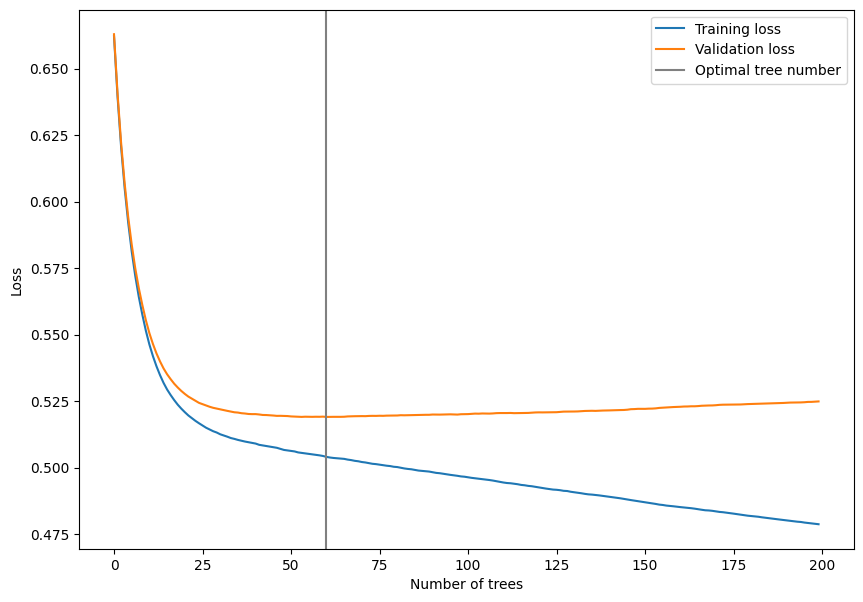

In [21]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(60, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

(<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>,
 <Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>)

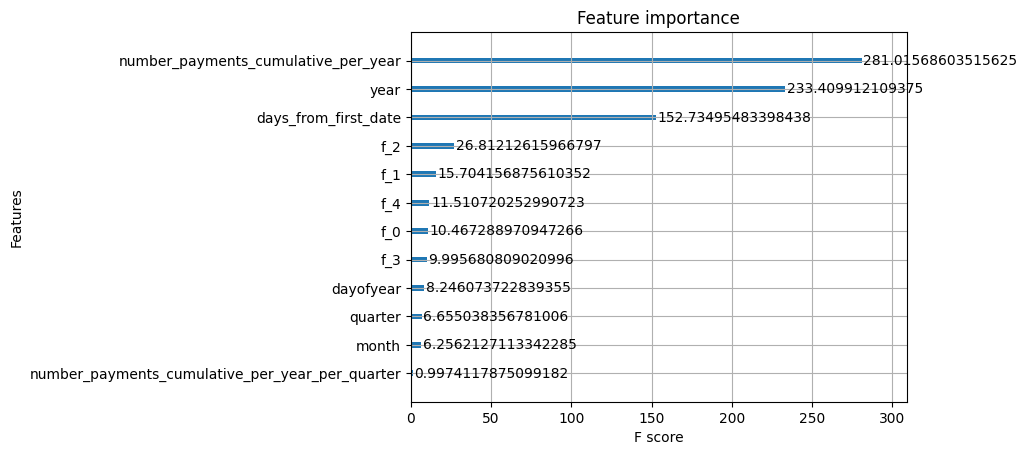

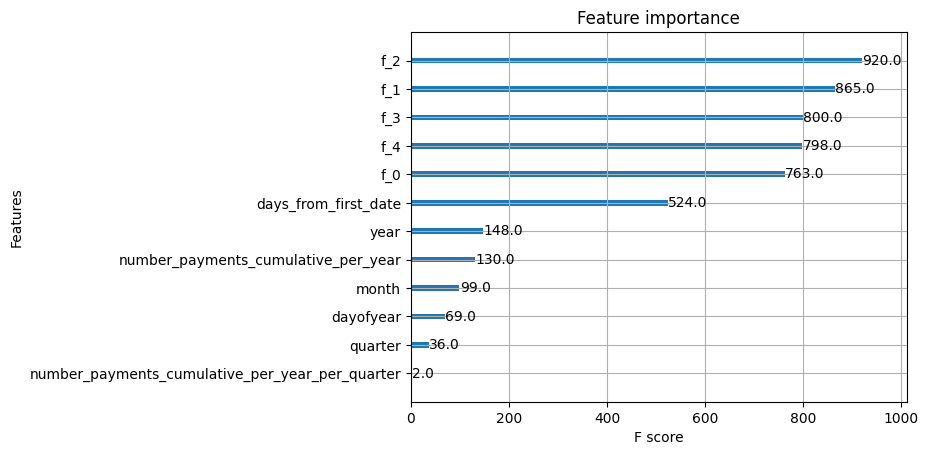

In [22]:
xgb.plot_importance(model, importance_type = "gain"), xgb.plot_importance(model, importance_type = "weight")

#### 6.2 Applying neural network classification

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)  

In [31]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping


#building the neural network
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=1,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/5
118154/118154 ━━━━━━━━━━━━━━━━━━━━ 126s 1ms/step - accuracy: 0.7081 - loss: 0.5668 - val_accuracy: 0.7418 - val_loss: 0.5243
Epoch 2/5
118154/118154 ━━━━━━━━━━━━━━━━━━━━ 126s 1ms/step - accuracy: 0.7455 - loss: 0.5208 - val_accuracy: 0.7395 - val_loss: 0.5231
Epoch 3/5
118154/118154 ━━━━━━━━━━━━━━━━━━━━ 127s 1ms/step - accuracy: 0.7449 - loss: 0.5180 - val_accuracy: 0.7396 - val_loss: 0.5348


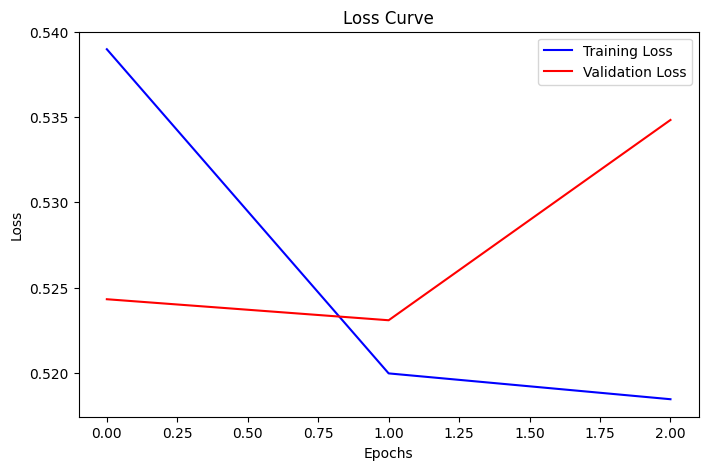

In [32]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

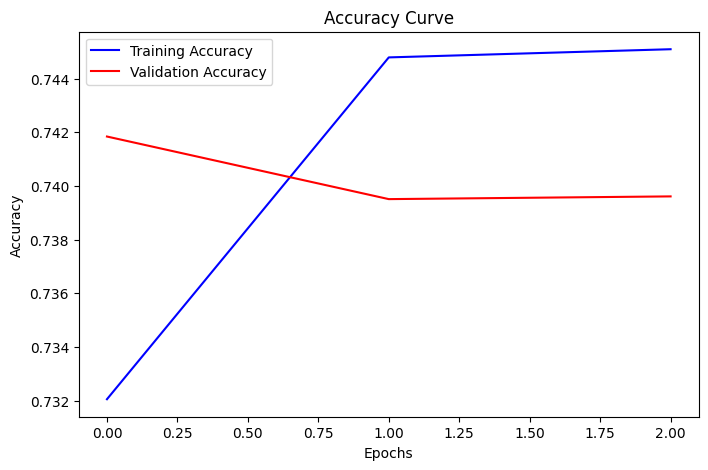

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()
